In [1]:
import mysql.connector
from sklearn.feature_extraction.text import CountVectorizer
from gensim import corpora, models
import gensim
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
import pyLDAvis.gensim_models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from gensim import matutils
from gensim.models import TfidfModel
from gensim.models import Phrases
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import pandas as pd
import numpy as np
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Naresh Kumar
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Naresh Kumar
[nltk_data]     S\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# Calling the mysql database to access the questions
conn = mysql.connector.connect(
    host='127.0.0.1',  
    user='root',  
    passwd='Naresh@30701',  
    db='questions' 
)

cur = conn.cursor()
cur.execute("SELECT question FROM Questions")

questions = cur.fetchall()

cur.close()
conn.close()
print(f"Number of questions extracted: {len(questions)}")

Number of questions extracted: 5745


In [3]:
#printing out the one word questions
one_worded_questions = [question[0] for question in questions if len(question[0].split()) == 1]
print(f"Number of one-worded questions: {len(one_worded_questions)}")
print("One-worded questions:")
for question in one_worded_questions:
    print(question)

Number of one-worded questions: 1433
One-worded questions:
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
Astronomy
Zoology
Music
Sociology
Geography
Anthropology
Chemistry
Biology
Physics
As

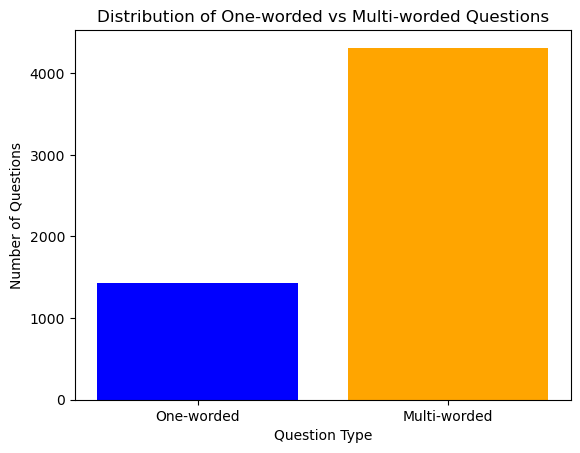

In [4]:
#Analysis for the one worded questions
word_counts = [len(question[0].split()) for question in questions]
one_worded_counts = sum(1 for count in word_counts if count == 1)
multi_worded_counts = len(questions) - one_worded_counts

labels = ['One-worded', 'Multi-worded']
counts = [one_worded_counts, multi_worded_counts]
plt.bar(labels, counts, color=['blue', 'orange'])
plt.xlabel('Question Type')
plt.ylabel('Number of Questions')
plt.title('Distribution of One-worded vs Multi-worded Questions')
plt.show()

In [5]:
#function for preprocessing of the questions
def preprocess(text):
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

preprocessed_questions = []
for question in questions:
    text = question[0]
    text = re.sub('[^a-zA-Z]', ' ', text)
    words = text.split()
    if len(words) > 1:
        tokens = preprocess(text)
        preprocessed_questions.append(tokens)
print(f"Number of questions after removing one-worded questions: {len(preprocessed_questions)}")

Number of questions after removing one-worded questions: 4312


In [7]:
# Vectorization
vectorizer = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False)
X = vectorizer.fit_transform(preprocessed_questions)

C:\Users\Naresh Kumar S\anaconda3\filesp\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [8]:
tokens = [token for question in preprocessed_questions for token in question]

# Term Frequency Analysis
term_freq = pd.Series(tokens).value_counts()
print(term_freq[:20])  # Print the 20 most common words

history        322
art            318
would          257
like           257
written        212
language       207
study          185
author         185
noun           181
look           171
mockingbird    170
u              161
american       161
world          161
government     161
religious      159
english        159
science        159
earth          159
father         134
Name: count, dtype: int64


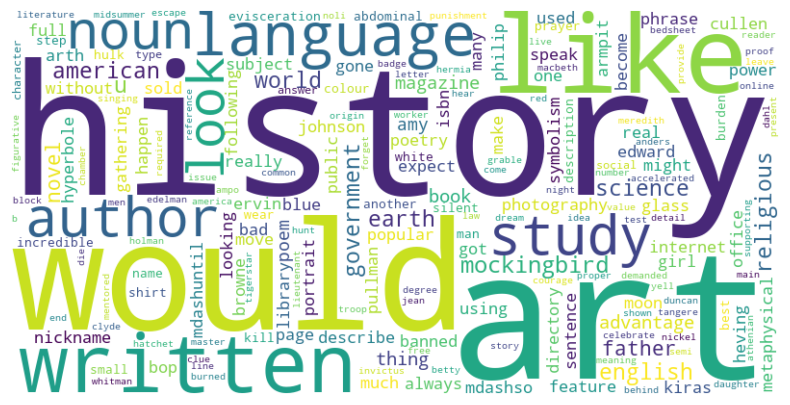

In [9]:
# word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(term_freq)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

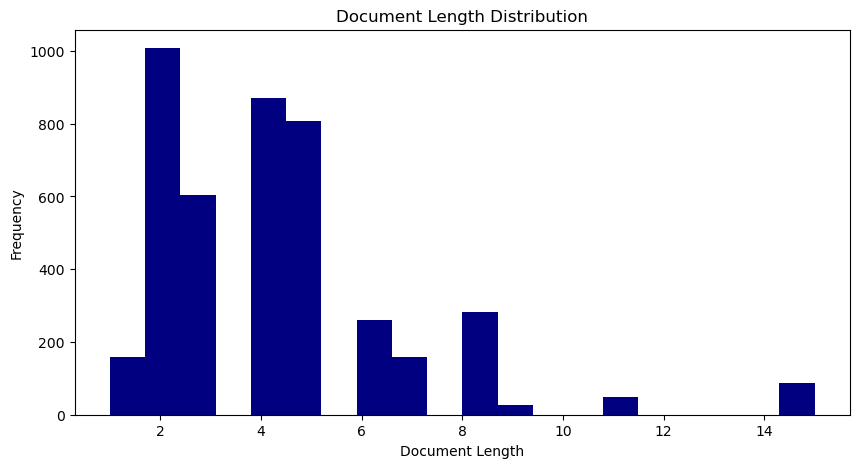

In [10]:
doc_lengths = [len(question) for question in preprocessed_questions]
plt.figure(figsize=(10, 5))
plt.hist(doc_lengths, bins=20, color='navy')
plt.title('Document Length Distribution')
plt.xlabel('Document Length')
plt.ylabel('Frequency')
plt.show()

In [11]:
# dictionary creation
dictionary = corpora.Dictionary(preprocessed_questions)
dictionary.filter_extremes(no_below=20, no_above=0.5)
corpus = [dictionary.doc2bow(text) for text in preprocessed_questions]

In [12]:
#model training
ldamodel = models.LdaModel(corpus, num_topics=3, id2word=dictionary, passes=30)
topic_assignments = [ldamodel.get_document_topics(bow) for bow in corpus]
dominant_topics = [max(topics, key=lambda x: x[1])[0] for topics in topic_assignments]

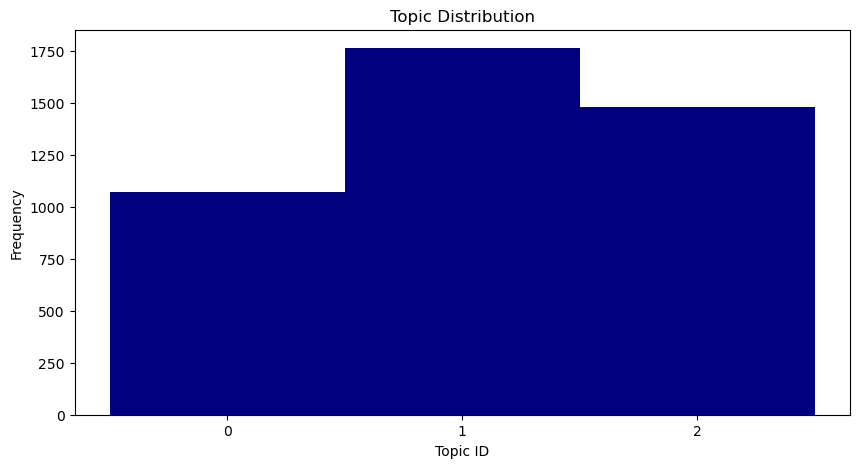

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(dominant_topics, bins=range(ldamodel.num_topics+1), align='left', color='navy')
plt.title('Topic Distribution')
plt.xlabel('Topic ID')
plt.ylabel('Frequency')
plt.xticks(range(ldamodel.num_topics))
plt.show()

In [14]:
# Compute Perplexity
print('Perplexity: ', ldamodel.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

Perplexity:  -5.122567640517336


In [15]:
#topic distribution
for i in range(ldamodel.num_topics):
    print(f"Topic {i}:")
    print(ldamodel.print_topic(i))
    

Topic 0:
0.026*"magazine" + 0.024*"noun" + 0.021*"type" + 0.016*"story" + 0.015*"pig" + 0.015*"phillips" + 0.015*"little" + 0.015*"james" + 0.015*"write" + 0.015*"apart"
Topic 1:
0.042*"history" + 0.039*"written" + 0.022*"author" + 0.021*"world" + 0.021*"government" + 0.021*"u" + 0.021*"american" + 0.020*"earth" + 0.020*"science" + 0.019*"literature"
Topic 2:
0.052*"art" + 0.038*"study" + 0.031*"language" + 0.026*"english" + 0.026*"religious" + 0.025*"burned" + 0.022*"advantage" + 0.019*"like" + 0.019*"mockingbird" + 0.017*"answer"


In [16]:
#trying with bigram and trigrams of words
bigram = Phrases(preprocessed_questions, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = Phrases(bigram[preprocessed_questions], threshold=100)  

# Apply the trained MWE detector to a corpus, using the result to train a Word2vec model
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [17]:
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]
data_words_bigrams = make_bigrams(preprocessed_questions)
data_words_trigrams = make_trigrams(preprocessed_questions)

In [18]:
# Dictionary creation
dictionary_bigram = corpora.Dictionary(data_words_bigrams)
dictionary_bigram.filter_extremes(no_below=20, no_above=0.5)

# Bag of words
corpus_bigram = [dictionary_bigram.doc2bow(text) for text in data_words_bigrams]

In [19]:
# Model Training
ldamodel_bigram = models.LdaModel(corpus_bigram, num_topics=3, id2word=dictionary_bigram, passes=15)
topic_assignments_bigram = [ldamodel_bigram.get_document_topics(bow) for bow in corpus_bigram]
dominant_topics_bigram = [max(topics, key=lambda x: x[1])[0] for topics in topic_assignments_bigram]

In [20]:
#model evaluation
print('Perplexity: ', ldamodel_bigram.log_perplexity(corpus_bigram))

Perplexity:  -5.1420951508963855


In [21]:
# printing the topics
topics = ldamodel_bigram.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.036*"art" + 0.027*"study" + 0.024*"written" + 0.021*"language" + 0.019*"world" + 0.019*"would" + 0.018*"burned" + 0.018*"english" + 0.018*"religious" + 0.018*"history"')
(1, '0.024*"mockingbird" + 0.023*"type" + 0.018*"damon" + 0.018*"ever" + 0.018*"find" + 0.018*"kathrine" + 0.018*"vampire" + 0.018*"diary" + 0.018*"want" + 0.018*"soundtrack"')
(2, '0.031*"history" + 0.030*"american" + 0.030*"government" + 0.030*"u" + 0.029*"earth" + 0.029*"science" + 0.020*"noun" + 0.020*"like" + 0.019*"author" + 0.019*"written"')


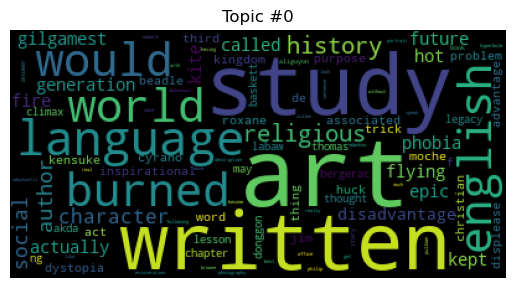

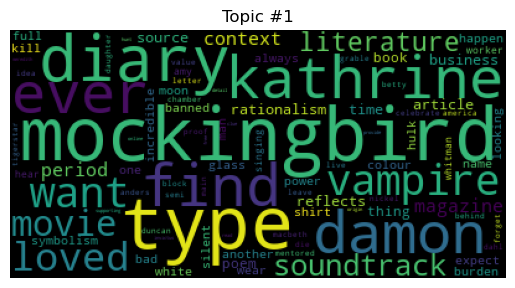

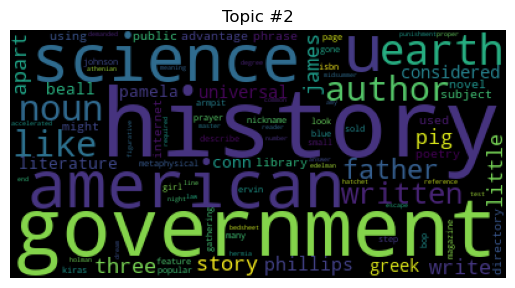

In [22]:
for t in range(ldamodel_bigram.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(ldamodel_bigram.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()


In [23]:
vis_data = pyLDAvis.gensim_models.prepare(ldamodel_bigram, corpus_bigram, dictionary_bigram)
pyLDAvis.display(vis_data)

In [26]:
tfidf = TfidfModel(corpus_bigram)
# converting the vector corpus into sparse matrix
sparse_corpus_tfidf = matutils.corpus2csc(tfidf[corpus_bigram])
# Transposing to have terms as rows and documents as columns
sparse_corpus_tfidf_transposed = sparse_corpus_tfidf.transpose()

In [29]:
# Training
kmeans = KMeans(n_clusters=5, random_state=0).fit(sparse_corpus_tfidf_transposed)

C:\Users\Naresh Kumar S\anaconda3\filesp\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [30]:
#Evaluating
print('Silhouette Score: ', silhouette_score(sparse_corpus_tfidf_transposed, kmeans.labels_))

Silhouette Score:  0.16436354281350507


In [31]:
#creating a dataframe
df = pd.DataFrame({'Question': [' '.join(question) for question in data_words_bigrams], 'Cluster': kmeans.labels_})
for i in range(kmeans.n_clusters):
    print(f"Cluster {i}:")
    print(df[df['Cluster'] == i]['Question'])
    print("\n")

Cluster 0:
1                           symbolism full moon power one
2                            popular feature bop magazine
3                             gathering blue kiras father
4          phrase might used describe metaphysical poetry
5       advantage using subject directory like interne...
                              ...                        
4305                greek literature considered universal
4306                   advantage disadvantage kite flying
4307                                         moche beadle
4308                             word associated dystopia
4309                                  american government
Name: Question, Length: 3379, dtype: object


Cluster 1:
14          u history
15      world history
41          u history
42      world history
68          u history
            ...      
4257    world history
4283        u history
4284    world history
4310        u history
4311    world history
Name: Question, Length: 322, dtype: object


Cluster